In [180]:
import pandas as pd
import numpy as np
import nltk
import random
import time
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from copy import copy, deepcopy
import collections
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
lmtzr=WordNetLemmatizer()

In [2]:
user_raw = pd.read_csv("/Users/MaxTan/Documents/CU_16fall/BDA/Project/Data/wow3_user2.csv", names = ["user_id", "review_count", "average_stars", 
                                               "friends", "fans", "votes_cool", "votes_funny", 
                                               "votes_useful", "num", "degree", "coefficient"])


In [3]:
business_raw = pd.read_csv("/Users/MaxTan/Documents/CU_16fall/BDA/Project/Data/wow3_business_mysql.csv", names = ["business_id", "name", "latitude", 
                                                           "longitude", "stars", "categories", 
                                                           "review_count", "open"])

In [4]:
review_raw = pd.read_csv("/Users/MaxTan/Documents/CU_16fall/BDA/Project/Data/wow3_review_mysql.csv", names = ["review_id", "user_id", "business_id", 
                                                       "stars", "text", "date", "votes_funny", 
                                                       "votes_useful"])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
all_raw = pd.read_csv("/Users/MaxTan/Documents/CU_16fall/BDA/Project/Data/wow3_all2.csv", names = ["business_id", 
                                                       "name", "stars_business","business_review_count",
                                                       "categories", "open", "review_id", 
                                                       "stars_review", "text", "date", "votes_funny", 
                                                       "votes_useful","user_id", "user_review_count", 
                                                       "average_stars","friends", "fans", "num", 
                                                       "degree", "coefficient"])


In [7]:
#1.Unigram:
sample_text =all_raw.text[:10]
for i in range(len(sample_text)):
    ly = sample_text[i].lower()
    ly = ly.translate(None, string.punctuation)
    try:
        tokens = nltk.word_tokenize(ly)
        tokens = [lmtzr.lemmatize(word) for word in tokens]
        tokens = [w for w in tokens if w not in stopwords.words("english")]
        print tokens
    except UnicodeDecodeError:
        #print tokens
        continue
    break


['ordered', 'chicken', u'wing', 'looked', 'unappetizing', 'especially', 'picked', 'one', u'feather', 'coming', 'understand', u'thing', 'happen', 'situation', u'wa', 'handled', 'unprofessionally', 'im', 'sure', 'server', u'wa', 'embarrassed', 'seemed', 'though', 'avoided', 'issue', u'wa', 'brought', 'attention']


In [12]:
#2. Rate Analysis of Open and Closed businesses
res = 0
cls = 0
for i in all_raw.open.values:
    if i=='T':
        res+=1
    else:
        cls+=1
print res,cls
subclose = all_raw[all_raw['open']=='F']
subopen = all_raw[all_raw['open']=='T']
print np.mean(subclose.average_stars),np.mean(subopen.average_stars)

93956 10435
3.73581025395 3.76976159053


In [113]:
#3. Business Rate Prediction(Time Series):
#Input: a given business_id
#Output: predicted result of next month's rate and model data visualization

In [149]:
temp = collections.Counter(all_raw.business_id.values).most_common(10)[0][0]
sub_business = all_raw[all_raw['business_id']==temp]

In [150]:
dates = [datetime.strptime(date,'%Y-%m-%d') for date in sub_business.date.values]
rate_predict = pd.DataFrame()
rate_predict['rate'] = pd.Series(sub_business.stars_review.values,index = pd.Series(dates))

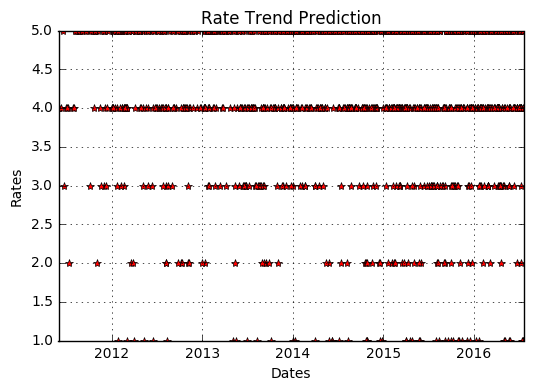

In [151]:
plt.plot_date(x=rate_predict.index.values, y=rate_predict.rate.values,fmt='r*')
plt.title('Rate Trend Prediction')
plt.ylabel('Rates')
plt.xlabel('Dates')
plt.grid(True)
plt.show()

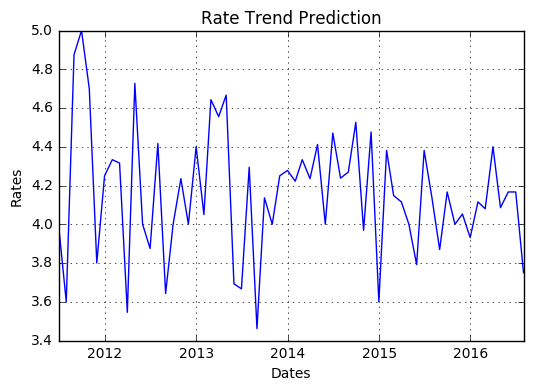

In [152]:
#Aggregation: group by month and take average
g = rate_predict.groupby(pd.TimeGrouper("M"))
rate_predict_avg = g.mean()
plt.plot_date(x=rate_predict_avg.index, y=rate_predict_avg.rate.values,fmt='b-')
plt.title('Rate Trend Prediction')
plt.ylabel('Rates')
plt.xlabel('Dates')
plt.grid(True)
plt.show()

In [153]:
#Rolling mean(Moving Average) of the monthly prediction:
moving_avg = pd.rolling_mean(rate_predict_avg,12)

rate_predict_moving_avg_diff = rate_predict_avg - moving_avg
rate_predict_moving_avg_diff.head(1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app


,rate
2011-06-30,NaN


In [171]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid(True)
    plt.show()
    
    #Perform Dickey-Fuller test:
    """print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput"""

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


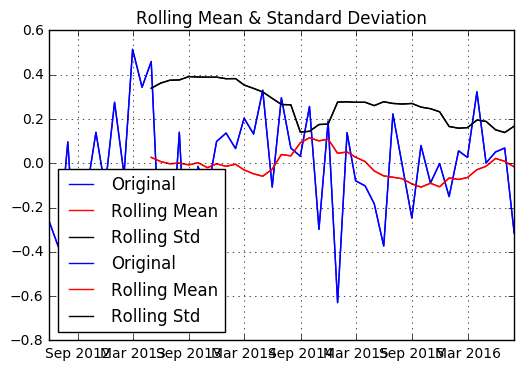

In [163]:
rate_predict_moving_avg_diff.dropna(inplace=True)
test_stationarity(rate_predict_moving_avg_diff)

In [167]:
#Exponentially weighted moving average:
expwighted_avg = pd.ewma(rate_predict_avg, halflife=12)


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  from ipykernel import kernelapp as app


In [ ]:
plt.plot(rate_predict)
plt.plot(expwighted_avg, color='red')
plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


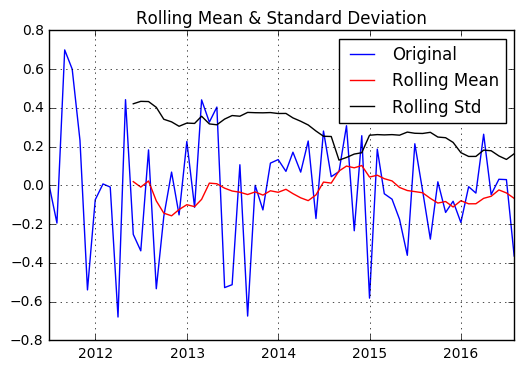

In [172]:
rate_predict_log_ewma_diff = rate_predict_avg - expwighted_avg
test_stationarity(rate_predict_log_ewma_diff)

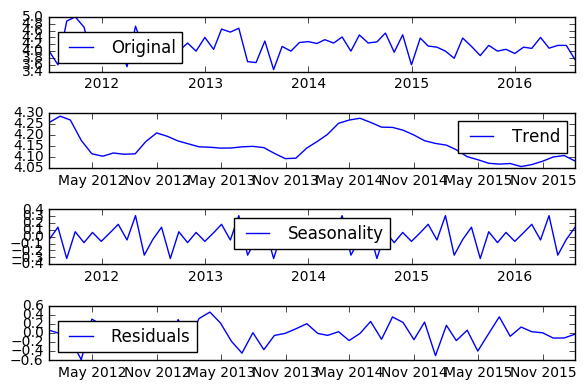

In [177]:
decomposition = seasonal_decompose(rate_predict_avg)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(rate_predict_avg, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()


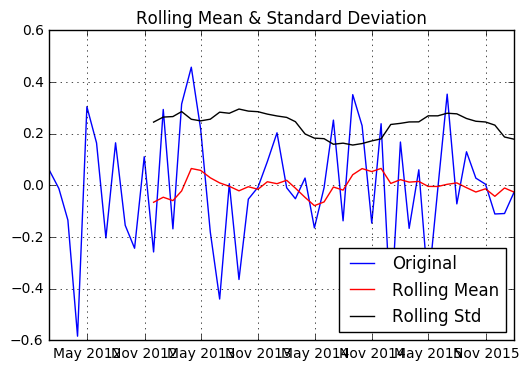

In [178]:
rate_predict_log_decompose = residual
rate_predict_log_decompose.dropna(inplace=True)
test_stationarity(rate_predict_log_decompose)

In [181]:
lag_acf = acf(rate_predict_log_decompose, nlags=20)
lag_pacf = pacf(rate_predict_log_decompose, nlags=20, method='ols')

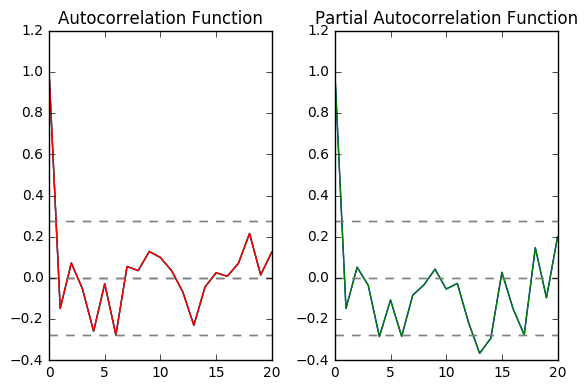

In [184]:
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rate_predict_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rate_predict_log_decompose)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rate_predict_log_decompose)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rate_predict_log_decompose)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

5.19946356247


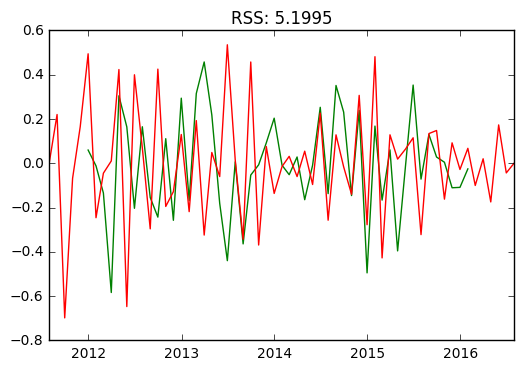

In [238]:
model = ARIMA(rate_predict_avg, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  

common = list(set(results_AR.fittedvalues.index).intersection(set(rate_predict_log_decompose.index)))

plt.plot(rate_predict_log_decompose,color = 'green')
plt.plot(results_AR.fittedvalues, color='red')


res = 0.0
for i in range(len(common)):
    res+=(rate_predict_log_decompose[rate_predict_log_decompose.index==common[i]].values[0][0] - results_AR.fittedvalues[results_AR.fittedvalues.index==common[i]].values[0])**2
print res
plt.title('RSS: %.4f'% res)

plt.show()

In [282]:
results_AR.fittedvalues.tail(10)

2015-10-31   -0.161899
2015-11-30    0.092394
2015-12-31   -0.027852
2016-01-31    0.067681
2016-02-29   -0.100076
2016-03-31    0.020409
2016-04-30   -0.174455
2016-05-31    0.173336
2016-06-30   -0.043381
2016-07-31    0.001007
Freq: M, dtype: float64

In [283]:
rate_predict_log_decompose.tail(3)

,rate
2015-11-30,-0.110432
2015-12-31,-0.108702
2016-01-31,-0.025237


In [240]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print predictions_AR_diff.head()

2011-07-31    0.000650
2011-08-31    0.220335
2011-09-30   -0.698100
2011-10-31   -0.067533
2011-11-30    0.165503
Freq: M, dtype: float64


In [241]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print predictions_AR_diff_cumsum.head()

2011-07-31    0.000650
2011-08-31    0.220985
2011-09-30   -0.477115
2011-10-31   -0.544648
2011-11-30   -0.379145
Freq: M, dtype: float64


In [245]:
rate_predict_avg.tail(3)

,rate
2016-05-31,4.166667
2016-06-30,4.166667
2016-07-31,3.750000


In [246]:
predictions_ARIMA_log = pd.Series(rate_predict_avg.values[0], index=rate_predict_avg.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_AR_diff_cumsum,fill_value=0)
#predictions_ARIMA_log

In [278]:
print results_AR.summary()

                             ARIMA Model Results                              
Dep. Variable:                 D.rate   No. Observations:                   61
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -29.633
Method:                       css-mle   S.D. of innovations              0.392
Date:                Sat, 10 Dec 2016   AIC                             65.266
Time:                        16:14:04   BIC                             71.598
Sample:                    07-31-2011   HQIC                            67.747
                         - 07-31-2016                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.0007      0.033      0.020      0.984        -0.063     0.065
ar.L1.D.rate    -0.5483      0.107     -5.142      0.000        -0.757    -0.339
                                    Roots   

In [260]:
type(rate_predict_avg.index[-1])

pandas.tslib.Timestamp

In [263]:
from pandas.tseries.offsets import *

In [271]:
start_date.isoformat()

'2016-07-31T00:00:00'

In [272]:
end_date.isoformat()

'2016-08-31T00:00:00'

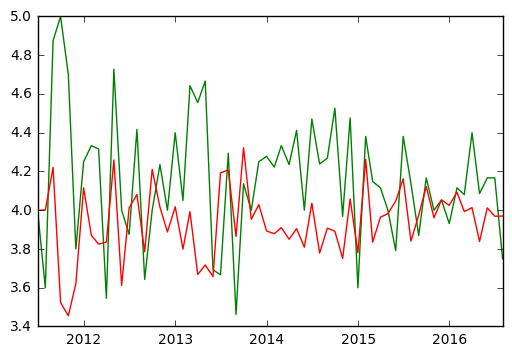

ValueError: cannot slice a 0-d array

In [275]:
plt.plot(rate_predict_avg,color='green')
plt.plot(predictions_ARIMA_log,color='red')
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_log-rate_predict_avg)**2)/len(ts)))
plt.show()

start_date = rate_predict_avg.index[-3] +DateOffset(months=0)
end_date =rate_predict_avg.index[-1] + DateOffset(months=0)

model.predict(start_date.isoformat(), end_date.isoformat())

6.26041248223


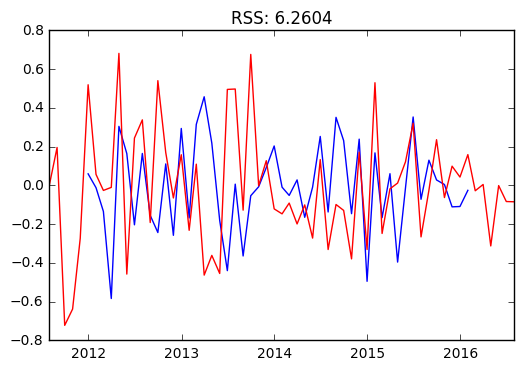

In [254]:
model = ARIMA(rate_predict_avg, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(rate_predict_log_decompose)
plt.plot(results_MA.fittedvalues, color='red')

common = list(set(results_MA.fittedvalues.index).intersection(set(rate_predict_log_decompose.index)))
res = 0.0
for i in range(len(common)):
    res+=(rate_predict_log_decompose[rate_predict_log_decompose.index==common[i]].values[0][0] - results_MA.fittedvalues[results_MA.fittedvalues.index==common[i]].values[0])**2
print res
plt.title('RSS: %.4f'% res)
plt.show()



6.81937731376


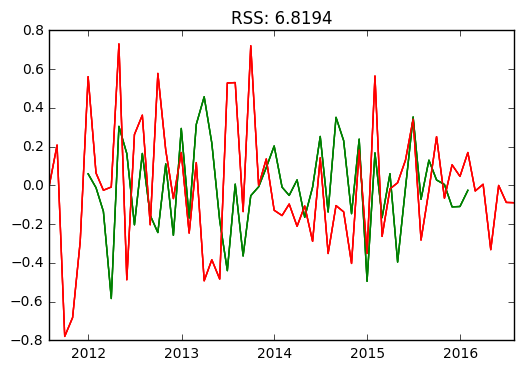

In [225]:
model = ARIMA(rate_predict_avg, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(rate_predict_log_decompose,color = 'green')
plt.plot(results_ARIMA.fittedvalues, color='red')

common = list(set(results_ARIMA.fittedvalues.index).intersection(set(rate_predict_log_decompose.index)))
res = 0.0
for i in range(len(common)):
    res+=(rate_predict_log_decompose[rate_predict_log_decompose.index==common[i]].values[0][0] - results_ARIMA.fittedvalues[results_ARIMA.fittedvalues.index==common[i]].values[0])**2
print res

plt.title('RSS: %.4f'% res)
plt.show()